## Simple A2C Pong Training based on 2 actions up/down

#### A2C
[Mnih, Volodymyr, et al. "Asynchronous methods for deep reinforcement learning." International conference on machine learning. 2016.](http://proceedings.mlr.press/v48/mniha16.pdf)


### Actor-Critic

*Actor critic* method is one of the popular *policy optimization* algorithms. This approach maximizes the expected return by pushing up the probabilities of actions that receive higher returns. Let $\pi_\theta$ denote a policy with parameters $\theta$. The policy gradient of performance $\mathcal{J}(\pi_\theta)$ is

$$ \nabla_\theta \mathcal{J}(\pi_\theta) = \underset{\tau\sim\pi_\theta}{\mathbb{E}}\left[ \sum^T_{t=0} \nabla_\theta \log \pi_\theta(a_t|s_t)A^{\pi_\theta}(s_t, a_t) \right],$$

where $\tau$ is a trajectory and $A^{\pi_\theta}$ is the advantage function for reducing variance of values. The *policy gradient algorithm* updates the parameters by adding this gradient.

$$\theta_{k+1} = \theta_k + \alpha \nabla_\theta \mathcal{J}(\pi_{\theta_k}),$$

where $\alpha$ is a learning rate. The agent is trained in an on-policy way because the parameters are updated by the current policy. We call the policy *Actor* which predicts probabilities of actions in each state, and call the value function *Critic* that predicts values of all state-action pairs. 


### Advantage Function

The advantage function effectively reduces the variance of values and is defined as follows.

$$ A(s,a) = Q(s,a) - V(s) $$

From this formula, we can replace Q with $r+\gamma V(s')$ and redefine Advantage function without using Action-Value function.

$$ A(s,a) = r + \gamma V(s') - V(s) $$

Now if we would like to review advantage function for the n-step TD algorithm, we can build it next way:
 
\begin{align*}
\hat{A}_t^{(1)} & := \delta_t = r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \\
\hat{A}_t^{(2)} & := \delta_t + \gamma \delta_{t+1} = r_{t+1} + \gamma r_{t+2} + \gamma^2 V(s_{t+2}) - V(s_t)  \\
...\\
\hat{A}_t^{(n)} & := \sum_{l=0}^{n} \gamma ^{l} \delta_{t+l} = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3}+...+ \gamma^{n-1} r_{t+n} + \gamma^{n} V(s_{t+n}) - V(s_t)
\end{align*}

### Generalized Advantage Estimator

The generalized advantage estimator GAE($\gamma,\lambda$) is defined as exponentially-weighted average of these $k$-step estimators:

\begin{align*}
\hat{A}_t^{\text{GAE}(\gamma, \lambda)} & = (1-\lambda) (\hat{A}_t^{(1)} + \lambda \hat{A}_t^{(2)} + \lambda^2 \hat{A}_t^{(3)} + ...) \\  
& = (1-\lambda) (\delta_t + \lambda (\delta_t + \gamma \delta_{t+1}) + \lambda^2 (\delta_t + \gamma \delta_{t+1} + \gamma^2 \delta_{t+2} ) + ...) \\  
& = (1-\lambda) ( \delta_t (1+\lambda+\lambda^2+...) + \gamma \delta_{t+1} (\lambda+\lambda^2+\lambda^3+...) + \gamma^2 \delta_{t+2} (\lambda^2+\lambda^3+\lambda^3+...) + ...) \\
& = (1-\lambda) \biggl( \delta_t \biggl(\frac{1}{1-\lambda}\biggl) + \gamma \delta_{t+1} \biggl(\frac{\lambda}{1-\lambda}\biggl) + \gamma^2 \delta_{t+2} \biggl(\frac{\lambda^2}{1-\lambda}\biggl) +  ...) \\
& = \sum_{l=0}^{\infty} (\gamma \lambda)^{l} \delta_{t+l}
\end{align*}

Ther are two notable special cases of this formula, obtained by setting $\lambda = 0$ and $\lambda = 1$.

\begin{align*}
\text{If }  \lambda=0,  \; \hat{A}_t^{\text{GAE}(\gamma,0)} & := \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) \\
\text{If }  \lambda=1,  \; \hat{A}_t^{\text{GAE}(\gamma,1)} & :=  \sum_{l=0}^{\infty} \gamma^{l} \delta_{t+l} = \sum_{l=0}^{\infty} \gamma^{l} r_{t+l} - V(s_t)
\end{align*}

### Maximization Entropy

Entropy is a measure of unpredictability or a measure of randomness. If we have actions with almost equal probabilities, the entropy over the actions will be the largest because it's completely unpredictable which action will be chosen. In view of the fact, we can encourage exploration by adding entropy maximization term to the loss function. The entropy $H$ with respect to the probability $p$ over actions is

$$ H(P) = - \sum_a p(a) \log p(a) $$


In [23]:
import os
import datetime

import numpy as np 
import gymnasium as gym
import ale_py

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    SummaryWriter = None  # type: ignore[misc, assignment]

from typing import Union


gym.register_envs(ale_py)

env = gym.make('PongDeterministic-v4')
observation, info = env.reset()
print(observation.shape)
print(type(env.observation_space.shape))
print(env.action_space)

(210, 160, 3)
<class 'tuple'>
Discrete(6)


## Define Model, Optimizer, Loss with Torch


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Prioritize device: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using CUDA.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS backend is available. Using MPS.")
else:
    DEVICE = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Using CPU.")


class ActorCriticNet(nn.Module):

    def __init__(self):
        """Initialize parameters and build model."""
        super(ActorCriticNet, self).__init__()

        # First we have same body for the actor and critic, in  our case 2 convolution layers network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4) # 19x19x32 / params 8*8*1*32 = 2048
        # (80+2*0-8)/4 + 1 = 19
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2) # 8*8*64 / params 5*5*32*64 = 51200
        # (19 +2*0-5)/2 + 1 = 8
        self.size = 8*8*64
        self.feature_dim = 512
        
        # fully connected layer after convolutional layers  with 512 features
        self.fc1 = nn.Linear(self.size, self.feature_dim) # 8*8*64*512 = 2097152

        #NOTE: We do here only single probability, probability of action choosing up action 
        self.UP = torch.tensor(2, dtype=torch.int8)
        self.DOWN = torch.tensor(3, dtype=torch.int8)

        self.fc_action = nn.Linear(self.feature_dim, 1) # fully connected 
        self.fc_critic = nn.Linear(self.feature_dim, 1)

    def forward(self, state):
        """Forward method implementation."""
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))

        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))

        #probability action up 
        up_probability = F.sigmoid(self.fc_action(x))
        action =  torch.where(torch.rand(up_probability.shape, device=DEVICE) < up_probability, self.UP, self.DOWN)
        action_prob = torch.where(action == self.UP, up_probability, (1-up_probability))
        value = self.fc_critic(x)

        return value, action, action_prob 

MPS backend is available. Using MPS.


## Image Preprocessing

In [25]:
def preprocess(image):
    """ Pre-process 210x160x3 uint8 frame into 6400 (80x80) 1D float vector. """
    image = torch.Tensor(image).to(DEVICE) #converts to float 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    image = image[35:195]
    image = image[::2,::2, 0]

    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1

    return image.unsqueeze(0).float() # (1,80,80)

def batch_preprocess(images):
    """ 
    Pre-process stacked images with shape [batch, stack, height, width, channels] into 
    preprocessed tensors and compute the difference between stacked frames.
    Usually shape will be like [batch, 2, 210, 160, 3] uint8 into [batch, 1, 80, 80] shape"""
    images = torch.Tensor(images).to(DEVICE) #converts to float 

    # add check in case we work with single env, where no batch axis/dim provided 
    if len(images.shape) < 5:
        images = images.unsqueeze(0) 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    images = images[:, :, 35:195, :, :]
    images = images[:, :, ::2,::2, 0]

    # erase background (background type 1) and # erase background (background type 2)
    images = torch.where((images == 144) | (images == 109), torch.tensor(0.0, device=DEVICE), images)

    images = (images != 0).float() # everything else (paddles, ball) just set to 1

    # Compute difference between consecutive frames in the stack
    diff_images = images[:, 1] - images[:, 0]

    return diff_images.unsqueeze(1)

## Rollout Buffer/Storage

For $𝑛$ n-step Actor-Critic, the rollout storage collects and stores the following components for each step  $𝑡$ in a batch of $𝑁$ parallel environments:
- states/observations $S_{t}$
- value estimations $V(s_{t})$
- rewards $r_{t}$
- actions $a_{t}$
- action log probabilities $\log \pi(a_{t}|s_{t}, {\theta})$ (in current pong game we store though just  $\pi(a_{t}|s_{t}, {\theta})$
- mask $m_{t}$ - a binary mask to indicate if the environment is still active (1 if active, 0 entered terminal state)

At each step $𝑡$, for environment $𝑏$, the collected data is:

$$ \{S_{t,b}, a_{t,b}, r_{t+1,b}, V(s_{t}), \log \pi(a_{t,b}|s_{t,b}, {\theta}), m_{t+1,b}  \} $$

This is collected iteratively for $n$ timesteps $N$ environments, then used for gradient updates in the Actor-Critic framework.
    
Additional important hyper parameters:
- number of steps $TD (n)$ error method 
- number of parallel environments executed 


In [26]:
import torch 
import numpy as np 

class RolloutStorage:
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy or n-steps as we like to call it in TD.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    It is only involved in policy and value function training but not action selection.
    """
    def __init__(self, 
                 obs_shape: any,
                 action_space: any,
                 num_steps: int = 1, 
                 n_envs: int = 1,
                 device: torch.device = torch.device("cpu")):
        
        self.num_steps = num_steps
        self.n_envs = n_envs

        self.obs_shape = obs_shape
        self.action_space = action_space
        self.device = device

        self.last_obs = None # To store the last observation between rollouts

        if action_space.__class__.__name__ == 'Discrete' or action_space.__class__.__name__ == 'MultiDiscrete':
            self.action_dim = 1
        else:
            self.action_dim = action_space.shape[0]

        # setup all the data   
        self.reset()  
    
    def reset(self) -> None:
        """
        Call reset, whenever we starting to collect next n-step rollout of data. 
        """
        self.obs = torch.zeros(self.num_steps, self.n_envs, *self.obs_shape, dtype=torch.float32, device=self.device)
        self.rewards = torch.zeros(self.num_steps, self.n_envs, 1,  dtype=torch.float32, device=self.device)
        self.values = torch.zeros(self.num_steps, self.n_envs,  1,  dtype=torch.float32, device=self.device)
        self.action_probs = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)
        self.actions = torch.zeros(self.num_steps, self.n_envs, self.action_dim, dtype=torch.float32, device=self.device)
        self.masks = torch.ones(self.num_steps, self.n_envs, 1, dtype=torch.int8, device=self.device)
        self.advantages = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)
        self.returns = torch.zeros(self.num_steps, self.n_envs, 1, dtype=torch.float32, device=self.device)

        self.step = 0
    
    def add(
        self,
        obs: torch.Tensor,
        actions: torch.Tensor,
        action_probs: torch.Tensor,
        values: torch.Tensor,
        rewards: torch.Tensor,
        masks: torch.Tensor
    ) -> None:
        """
        :param obs: Observations
        :param action: Actions
        :param action_log_probs: log probability of the action
            following the current policy.
        :param values: estimated value of the current state
            following the current policy.
        :param rewards: rewards
        :param masks: indicate env is still active 
        """
        # self.obs[self.step].copy_(obs)
        # self.actions[self.step].copy_(actions)
        # self.action_log_probs[self.step].copy_(action_log_probs)
        # self.values[self.step].copy_(values)
        # self.rewards[self.step].copy_(rewards)
        # self.masks[self.step].copy_(masks)
        self.obs[self.step].copy_(obs)
        self.actions[self.step].copy_(actions)
        self.action_probs[self.step] = action_probs.clone() #keep gradients
        self.values[self.step] = values.clone() #keep gradients
        self.rewards[self.step].copy_(rewards)
        self.masks[self.step].copy_(masks)

        self.step = (self.step + 1) % self.num_steps # hopefully thios % is actually not needed here

        # TODO: Implement TD(lambda) support  with GAE(lambda) - Generalized Advantage Estimation
        # once we calculate here all the advantages and returns next step will be to calculate loss and run the optimizer and update model weights 
        # we need special method to collect rollouts, compute returns here
        # then after that method which calculates error and update models 
        # after this all done we go to next step and calculate more 
    def compute_returns_and_advantages(
            self,
            last_values: torch.Tensor,
            gamma: float = 0.99,
            use_gae: bool = False,
            gae_lambda: float = 1.0) -> None:
        """
        Post-processing step: compute the advantages A using TD(n) error method, to use in the gradient calculation in future
            - TD(1) or A_1 is one-step estimate with bootstrapping delta_t = (r_{t+1} + gamma * v(s_{t+1}) - v(s_t))
            ....
            - TD(n) or A_n is n-step estimate with bootstrapping SUM_{l=0}^{n}(gamma^{l}*delta_{t+l})
               (r_{t+1} + gamma*r_{t+2} + gamma^2*r_{t+3} + .....+ gamma^(n+1)*v(s_{t+n+1}) - v(s_t))
        
        In case we have use_gae = True, meaning we using Generalized Advantage Estimation, in this case advantage calculated next way:

            - A_t^gae(gamma,lambda) = SUM_{l=0}^{\infty}( (gamma*lambda)^{l} * \delta_{t+l})

        :param last_values: state values estimation for the last step (one for each env)
        :param gamma: discount to be used in reward estimation
        :param use_gae:  use Generalized Advantage Estimation 
        :param gae_lambada: factor for trade off of bias vs variance for GAE
        """
        if not use_gae: 
            returns = last_values.detach()
            for step in reversed(range(self.num_steps)):
                returns = self.rewards[step] + gamma * self.masks[step] * returns
                advantages = returns - self.values[step].detach()

                self.advantages[step] = advantages.detach()
                self.returns[step] = returns.detach()
        else: 
            gae = 0
            for step in reversed(range(self.num_steps)):
                if step == self.num_steps - 1:
                    next_values = last_values.detach()
                else:
                    next_values = self.values[step+1].detach()
                delta = self.rewards[step] + gamma * self.masks[step] * next_values - self.values[step].detach() #td_error
                gae = delta + gamma * gae_lambda * self.masks[step] * gae
                self.advantages[step] = gae.detach()
            
            #R_t = A_t{GAE} + V(s_t) 
            self.returns = self.advantages + self.values.detach()
        

## A2C Agent 

### **Overall Loss**
The combined loss for **Advantage Actor-Critic (A2C)** is the weighted sum of the policy loss, value function loss, and entropy loss:

$$ L = L_{\text{policy}} + c_1 L_{\text{value}} + c_2 L_{\text{entropy}}, $$

where $c_1$ and $c_2$ control the relative contribution of value and entropy losses. By balancing these terms, A2C ensures stable training and effective policy improvement.

In [27]:
from collections import deque

class A2CAgent:
    """
    Advantage Actor Critic (A2C)
    :param env(gym.Env): The environment to learn from / openAI Gym environment - vector environment
    :param n_steps: The number of steps to run for each environment per update
        (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
    :param gamma: Discount factor
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
        Equivalent to classic advantage when set to 1.
    :param ent_coef: Entropy coefficient for the loss calculation
    :param vf_coef: Value function coefficient for the loss calculation
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator.
         Equivalent to classic advantage when set to 1.
    :param device: Device (cpu, cuda, ...) on which the code should be run.
    """
    def __init__(self,
                 env: gym.vector.VectorEnv,
                 n_steps: int = 5,
                 gamma: float = 0.99,
                 use_gae: bool = False,
                 gae_lambda: float = 1.0,
                 ent_coef: float = 0.01,
                 min_ent_coef: float = 0.001,
                 lr: float = 1e-3,
                 vf_coef: float = 0.5,
                 max_grad_norm: float = 0.5,
                 device: torch.device = torch.device("cpu"),
                 save_path: str = 'a2c_pong'):
        
        self.env = env
        self.n_steps = n_steps
        self.n_envs = env.num_envs

        self.gamma = gamma
        self.use_gae = use_gae
        self.gae_lambda = gae_lambda
        self.max_grad_norm = max_grad_norm

        self.entropy_coef = ent_coef
        self.min_entropy_coef = min_ent_coef
        self.value_loss_coef = vf_coef
        self.device = device
        self.save_path = save_path

        # network and optimizer 
        self.actor_critic = ActorCriticNet().to(self.device)
        self.optimizer = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)

        # rollout storage
        self.rollout_storage =  RolloutStorage(
            (1, 80, 80), # this obs shape is diff of 2 processed frames 
            self.env.action_space, 
            num_steps=n_steps, 
            n_envs=self.n_envs, 
            device=self.device)

  
    def collect_rollouts(self):
        """
        Collect experiences using the current policy and fill a ``RolloutBuffer``.
        The term rollout here refers to the model-free notion and should not
        be used with the concept of rollout used in model-based RL or planning.
        """

        last_obs = self.rollout_storage.last_obs 
        self.rollout_storage.reset()

        for _ in range(self.n_steps):
            # with torch.no_grad():
            values, actions, action_probs =  self.actor_critic(last_obs)
            # print(action_log_probs)
            # print(values)
            # print(actions)

            # Take actions in env and look the results
            obs, rewards, terminates, truncates, infos = self.env.step(actions)

            # Updating global number of steps agent done, while learning
            self.num_timesteps += self.env.num_envs

            dones = (terminates | truncates)
            masks = torch.tensor(1 - dones, dtype=torch.float32).unsqueeze(-1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)

            maybeepinfo = infos.get('episode')
            if maybeepinfo:
                self._extract_episode_data(maybeepinfo, infos.get('_episode'))

            self.rollout_storage.add(last_obs, 
                            actions, 
                            action_probs,
                            values,
                            rewards,
                            masks)
            
            # Reset terminated environments, will have issues with vectorenv builtin autoreset
            # for i, done in enumerate(terminated):
            #     if done:
            #      next_obs[i], _ = envs.reset_at(i)
            
            last_obs = batch_preprocess(obs)

        # compute values for the last timestamp
        #with torhc.no_grad():
        last_values, _, _  = self.actor_critic(last_obs)

        self.rollout_storage.compute_returns_and_advantages(
            last_values, 
            self.gamma,
            self.use_gae,
            self.gae_lambda)
        self.rollout_storage.last_obs = last_obs

        # TODO: add here besides rollouts find the path ending

    def learn(self):
        """
        Update policy using the currently gathered
        rollout buffer (one gradient step over whole data).
        
        We have same network for both actor(policy) and critic(value)

        For actor we calculate gradient accent to maximize accumulated n-step updates: action log probabilities * estimate of advantage function,
        where for last state one step update advantage function, for second last state two step update advantage function and so on 
          advantage = (r_{t+1} + gamma * v(s_{t+1}) - v(s_t))
        Additionally for actor we add entropy  dto favor exploration 

        For critic we calculate gradient decent to minimize mean squared error between estimated returns and value estimation for the state,
        where for last state one step return function, for second last state two step return function and so on 
          return = (r_{t+1} + gamma * v(s_{t+1}))
        """
        advantages = self.rollout_storage.advantages
        action_probs = self.rollout_storage.action_probs
        returns = self.rollout_storage.returns
        values = self.rollout_storage.values
        
        
        # 1 normalize advantages from the rolloutbuffer, it's good practice
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # 2. Policy gradient loss or Actor gradient loss (gradient only on the log probs) 
        #  here we have gradient accent, so added {-}
        policy_loss = -(advantages * torch.log(action_probs)).mean()

        # 3. Value loss using the TD(n) n step error  target  (gradient only on values)
        # here we have gradient decent, so keep it
        value_loss = F.mse_loss(values, returns)

        # 4. Entropy loss to favor exploration  (gradient on log probs)
        #  here we have gradient accent so added {-}
        entropy_loss = -torch.mean(-(action_probs * torch.log(action_probs + 1e-10) +
        (1.0-action_probs)*torch.log(1.0-action_probs+1e-10)))
        
        # 5. Combine total loss for the network 
        loss = policy_loss + self.value_loss_coef * value_loss  +  self.entropy_coef * entropy_loss

        # 6. Optimization step
        self.optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.max_grad_norm)
        self.optimizer.step()
        return loss, policy_loss, value_loss, entropy_loss

    def train(self, total_timesteps: int = 1e5, log_interval: int = 100):
        """Train the agent."""

        obs, _ = self.env.reset()
        self.rollout_storage.last_obs = batch_preprocess(obs)

        self.num_timesteps = 0
        self.episode_rewards = deque(maxlen=15)
        self.episode_lengths = deque(maxlen=15)
        # Calculate the updates
        update = 1

        while self.num_timesteps < total_timesteps:
            self.collect_rollouts()
            loss, policy_loss, value_loss, entropy_loss = self.learn()
            
             # Display training infos
            if update % log_interval == 0 and len(self.episode_rewards) > 1:
                print(
                    "Updates {}, num timesteps {}/{} Mean Length {:.1f}\n"
                    "Loss {:.4f}: Policy {:.4f} Value {:.4f} Entropy {:.4f}\n"
                    "Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}"
                    .format(
                        update, self.num_timesteps, total_timesteps, np.mean(self.episode_lengths),
                        loss, policy_loss, value_loss, entropy_loss,
                        len(self.episode_rewards), np.mean(self.episode_rewards),
                        np.median(self.episode_rewards), np.min(self.episode_rewards),
                        np.max(self.episode_rewards)
                    )
                )
                
                if self.entropy_coef != 0.0:
                    self.entropy_coef = max(self.min_entropy_coef, self.entropy_coef * 0.98) # 230 * 100 * 16 * 5 ~ 1.84 mln steps from 0.01 to 0.001
                
                if update % (10 * log_interval) == 0:
                    print('Saving checkpoint...')
                    torch.save(self.actor_critic.state_dict(), f'./models/checkpoint_{self.save_path}.pth')

                if  np.mean(self.episode_rewards) == 21:
                    print('Saving best solution, finishing training...')
                    torch.save(self.actor_critic.state_dict(), f'./nodels/checkpoint_{self.save_path}.pth')
                    break


            update += 1

    def _extract_episode_data(self, episode_data, episode_flags):
        """
        Extract data for environments where '_episode' is True and append it to 
        self.episode_info_buffer deque
            {'r': -21.0, '_r': True, 'l': 944, '_l': True, 't': 5.089006, '_t': True}- example
            r - cumulative reward
            l - episode length
            t - elapsed time since beginning of episode

        :param episode_data: dict, data from environments
        :param episode_flags: np.ndarray, boolean array indicating done environments
        """
        done_envs = np.where(episode_flags)[0]  # Get indices of done environments
    
        for env_index in done_envs:
            env_specific_data = {}
            for key, value in episode_data.items():
                if isinstance(value, np.ndarray):  # Ensure it's an array
                    env_specific_data[key] = value[env_index]
            self.episode_rewards.append(env_specific_data['r'])
            self.episode_lengths.append(env_specific_data['l'])


## Train and more

In [28]:
from gymnasium.wrappers import FrameStackObservation, RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv


# Wrap with RecordEpisodeStatistics for the future logs
# NOTE: Sadly, not possible to pass in FrameStackObservation with argument of stacking 2 frames
# envs = gym.make_vec('PongDeterministic-v4', 
#                     num_envs=4, 
#                     vectorization_mode="sync", 
#                     wrappers=(gym.wrappers.RecordEpisodeStatistics,))

# Define a factory function for creating environments with wrappers
def make_env(env_id, num_stack):
    def _init():
        env = gym.make(env_id)
        # Wrap with RecordEpisodeStatistics
        env = RecordEpisodeStatistics(env)
        # Wrap with FrameStack
        env = FrameStackObservation(env, stack_size=num_stack)  
        return env
    return _init

# Create the vectorized environment
num_envs = 4
env_id = "PongDeterministic-v4"
stack_size = 2 # 2 frames

envs = SyncVectorEnv([make_env(env_id, 2) for _ in range(num_envs)])

# 128 * 16 = 2048 steps per update
agent = A2CAgent(envs, n_steps=256,
                  use_gae=True, 
                  gae_lambda=0.95, 
                  gamma=0.99, 
                  ent_coef=0.01, 
                  device=DEVICE, 
                  lr=1e-3,
                  save_path='a2c_gae_095_g_099_pong')
agent.train(total_timesteps=1e6, log_interval=5)
     
# TODO: Based on result 2, we have issue from what I see it finds perfect strategy as early as in 10-14 min, but then pushed to search inperfect 
#       strategies, when jumps to -15, even -21, and then gets back to good one slowly until converges in 24 min. I need to see how to deal with such 
#       effects in future. 
#       Also may be add finish when mean is basically max of points - 21 points, just finish training, as doesn't make to look further after we reached
#       max of points 


# TODO: 1.[DONE] Categorical Pong A2C, 
#       2.[DONE] GAE implementaiton, 
#       3.[DONE]Continuous implementation A2C 
#       4. LTSM implementaition A2C last layer, 
#       5.[DONE] A3C implementation  
#       6. May be write vanilla gradients with baselines where baseline is Value function estimate neural network including regularisation on it ???,
#          https://youtu.be/AKbX1Zvo7r8?feature=shared&t=1654 (just may be cool idea, but keep low priority for now





Updates 5, num timesteps 5120/1000000.0 Mean Length 885.5
Loss 0.0837: Policy 0.0098 Value 0.1614 Entropy -0.6773
Last 2 training episodes: mean/median reward -21.0/-21.0, min/max reward -21.0/-21.0
Updates 10, num timesteps 10240/1000000.0 Mean Length 1136.1
Loss 0.0525: Policy -0.0009 Value 0.1202 Entropy -0.6800
Last 7 training episodes: mean/median reward -20.0/-21.0, min/max reward -21.0/-16.0
Updates 15, num timesteps 15360/1000000.0 Mean Length 1008.9
Loss 0.0999: Policy 0.0154 Value 0.1811 Entropy -0.6364
Last 14 training episodes: mean/median reward -20.4/-21.0, min/max reward -21.0/-16.0
Updates 20, num timesteps 20480/1000000.0 Mean Length 922.4
Loss 0.0459: Policy 0.0028 Value 0.0991 Entropy -0.6803
Last 15 training episodes: mean/median reward -20.9/-21.0, min/max reward -21.0/-20.0
Updates 25, num timesteps 25600/1000000.0 Mean Length 932.5
Loss 0.0466: Policy 0.0017 Value 0.1026 Entropy -0.6874
Last 15 training episodes: mean/median reward -20.9/-21.0, min/max reward -21

### Review video result

In [29]:
import os
import imageio
import numpy as np
from IPython.display import Video, display, HTML

def record_video(env, policy, out_directory, out_name, fps=60):
    """
    Generate a replay video of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video.
    :param fps: Frames per second.
    """
    images = []
    done = False
    obs, _ = env.reset()
    img = env.render()

    while not done:
        # Preprocess the observation, set input to network to be difference
        state = batch_preprocess(obs)

        # calculate actions and values
        value, action, action_prob  = policy(state)

        obs, reward, terminated, truncated, _ = env.step(action) 
        img = env.render()
        images.append(img)
        done = terminated or truncated
    
    # Save the video
    video_path = os.path.join(out_directory, out_name)
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)
    
    # Display the video in Jupyter notebook
    display(Video(video_path, embed=True, width=640, height=480))

In [32]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
env = FrameStackObservation(env, stack_size=2)

eval_model = ActorCriticNet().to(DEVICE)
eval_model.load_state_dict(torch.load('./models/checkpoint_a2c_pong.pth'))
# Ensure the model is in evaluation mode
eval_model.eval()

record_video(env, eval_model, './videos', 'output_pong_a2c.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


<video width="640" height="480" controls>
  <source src="../assets/videos/output_pong_a2c.mp4" type="video/mp4">
</video>

### OFFTOPIC      

torch.Size([4, 1, 80, 80])


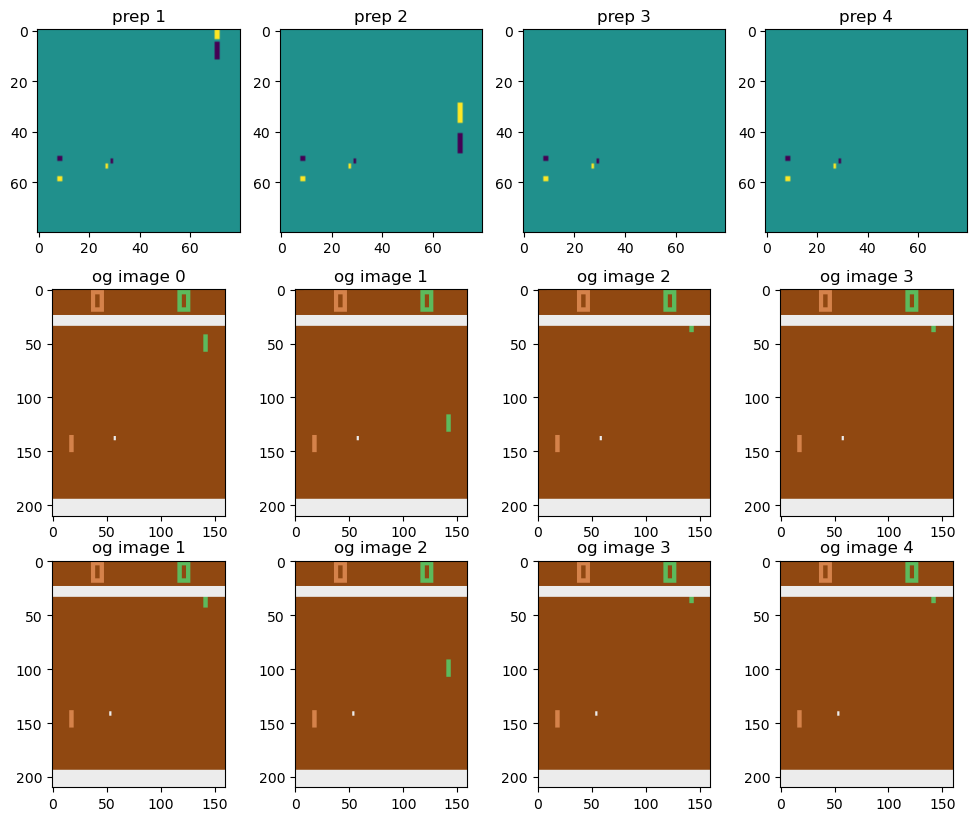

tensor([[0.0153],
        [0.0158],
        [0.0152],
        [0.0152]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2],
        [3],
        [2],
        [2]], device='mps:0', dtype=torch.int8)
None
tensor([[0.4946],
        [0.5051],
        [0.4944],
        [0.4944]], device='mps:0', grad_fn=<WhereBackward0>)
torch.Size([4, 1]) torch.Size([4, 1]) torch.Size([4, 1])
True
False
False
True
False


In [5]:
from gymnasium.wrappers import FrameStackObservation, RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv


# Define a factory function for creating environments with wrappers
def make_env(env_id, num_stack):
    def _init():
        env = gym.make(env_id)
        # Wrap with RecordEpisodeStatistics
        env = RecordEpisodeStatistics(env)
        # Wrap with FrameStack
        env = FrameStackObservation(env, stack_size=num_stack)  
        return env
    return _init

# Create the vectorized environment
num_envs = 4
env_id = "PongDeterministic-v4"
stack_size = 2 # 2 frames

envs = SyncVectorEnv([make_env(env_id, 2) for _ in range(num_envs)])

import matplotlib
import matplotlib.pyplot as plt

envs.reset()
_, _, _, _, _= envs.step([0]*num_envs)
# get a frame after 20 steps - that's about the number needed to see the full screen with gameplay
for _ in range(20):
    frames, _, _, _, _ = envs.step(np.random.choice([2, 3], num_envs))

processed_frames = batch_preprocess(frames)
print(processed_frames.shape) 

plt.figure(figsize=(12, 10)) # 12 inches wide and 6 inch tall
for i in range(num_envs):
    plt.subplot(3,4,i+1)
    plt.imshow(processed_frames[i][0].cpu())
    plt.title(f'prep {i+1}')

    plt.subplot(3,4, i + 5)
    plt.imshow(frames[i][0])
    plt.title(f'og image {i}')

    plt.subplot(3,4, i + 9)
    plt.imshow(frames[i][1])
    plt.title(f'og image {i+1}')

plt.show()
model = ActorCriticNet().to(DEVICE)
value, action, action_prob  = model(processed_frames)
print(value)
print(value.grad_fn)
print(action)
print(action.grad_fn)
print(action_prob)
print(value.shape, action.shape, action_prob.shape)
rollouts = RolloutStorage((1,80,80), envs.action_space, 5, 4)
rollouts.add(processed_frames, action, action_prob, value, torch.Tensor([[0]]*4), torch.Tensor([[1]]*4))
print(rollouts.values[0].requires_grad)
print(rollouts.values[0].grad_fn)
print(rollouts.obs[0].requires_grad)
print(rollouts.actions[0].requires_grad)
print(rollouts.action_probs[0].requires_grad)
print(rollouts.rewards[0].requires_grad)

In [6]:
def trace_to_params(grad_fn):
    if grad_fn is None:
        return "None (detached from graph)"
    visited = set()
    trace = []
    x = 0
    while grad_fn is not None and grad_fn not in visited and x < 100:
        visited.add(grad_fn)
        trace.append(str(grad_fn))
        if hasattr(grad_fn, 'next_functions'):
            for next_fn, _ in grad_fn.next_functions:
                if hasattr(next_fn, 'variable'):  # Check if linked to a parameter
                    trace.append(f"Connected to parameter: {next_fn.variable}")
        grad_fn = grad_fn.next_functions[0][0] if grad_fn.next_functions else None
        x += 1
    return " -> ".join(trace)

def trace_grad_fn(grad_fn):
    if grad_fn is None:
        return "None (detached from graph)"
    trace = []
    x = 0
    while grad_fn is not None and x < 5:
        trace.append(str(grad_fn))  # Record the current grad_fn
        grad_fn = grad_fn.next_functions[0][0] if grad_fn.next_functions else None
        x += 1
    return " -> ".join(trace)

print(trace_to_params(rollouts.action_probs[0].grad_fn))

rollouts.action_probs[0].sum().backward()

# Check if gradients exist in the model's parameters
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient: {param.grad.norm()}")
    else:
        print(f"{name} gradient: None")

# Zero gradients manually
# for param in model.parameters():
#     if param.grad is not None:
#         param.grad.zero_()

<SelectBackward0 object at 0x12d469bd0> -> <CopySlices object at 0x12d4694b0>
conv1.weight gradient: 0.014625892974436283
conv1.bias gradient: 0.040487635880708694
conv2.weight gradient: 0.09339422732591629
conv2.bias gradient: 0.07458431273698807
fc1.weight gradient: 0.27505677938461304
fc1.bias gradient: 0.21985942125320435
fc_action.weight gradient: 0.12108314037322998
fc_action.bias gradient: 0.49993306398391724
fc_critic.weight gradient: None
fc_critic.bias gradient: None
